# TNS Ledger Maker

Access CSV downloads from TNS and produce a DESI ToO ledger.

In [1]:
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)

## Access CTIO-4m-DECAM Data

Grab CSV data downloaded from TNS sent from DESIRT.

The search is specifically from the GAMA15 fields observed by DECam from late March to mid-April 2021.

In [3]:
data = ascii.read('desirt_tns_20210415.csv')
data

ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
int64,str10,str12,str12,int64,int64,int64,int64,str19,str19,int64,str19,int64,str31,int64,int64,int64,int64,float64,str7,str23,str10,int64,int64
81679,AT 2021jik,14:21:45.192,+00:52:18.84,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,22.0967,g-Sloan,2021-04-09 07:05:59.712,DESIRT_Bot,--,--
81678,AT 2021jij,14:07:44.160,+00:22:08.76,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,24.8906,g-Sloan,2021-04-09 07:22:06.528,DESIRT_Bot,--,--
81677,AT 2021jii,14:46:51.192,-01:26:18.60,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,22.779,g-Sloan,2021-04-06 08:26:05.280,DESIRT_Bot,--,--
81676,AT 2021jih,14:45:46.224,-03:44:52.08,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,22.7756,g-Sloan,2021-04-06 08:29:59.424,DESIRT_Bot,--,--
81675,AT 2021jig,14:37:12.504,-01:00:12.60,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,24.5633,g-Sloan,2021-04-06 08:23:28.032,DESIRT_Bot,--,--
81674,AT 2021jif,14:36:28.488,-03:00:12.96,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,24.5871,g-Sloan,2021-04-06 08:31:17.184,DESIRT_Bot,--,--
81673,AT 2021jie,14:35:21.072,-01:30:21.96,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,27.3425,g-Sloan,2021-04-06 08:23:28.032,DESIRT_Bot,--,--
81672,AT 2021jid,14:34:57.432,-02:05:27.60,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,23.7217,g-Sloan,2021-04-06 08:23:28.032,DESIRT_Bot,--,--
81671,AT 2021jic,14:33:10.080,-02:02:37.68,--,--,--,--,DESIRT,DESIRT,--,DESIRT,--,CTIO-4m - DECAM,--,1,1,--,25.5236,g-Sloan,2021-04-06 08:23:28.032,DESIRT_Bot,--,--


### Diagnostic Plots

In [4]:
ra, dec = data['RA'], data['DEC']
mag = data['Discovery Mag/Flux']
mag_cut = 23

filters = data['Discovery Filter']
print(np.unique(filters, return_counts=True))
coords = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.degree), frame='icrs')

(<Column name='Discovery Filter' dtype='str7' length=3>
g-Sloan
r-Sloan
z-Sloan, array([183,  19,   3]))


Text(0, 0.5, 'count')

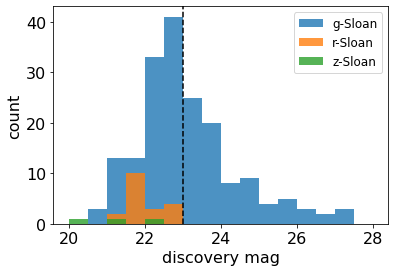

In [5]:
for filt in np.unique(filters):
    plt.hist(mag[filters==filt], bins=np.linspace(20,28,17), alpha=0.8, label=filt)
plt.axvline(mag_cut, color='k', ls='--')
plt.legend(fontsize=12)
plt.xlabel('discovery mag')
plt.ylabel('count')

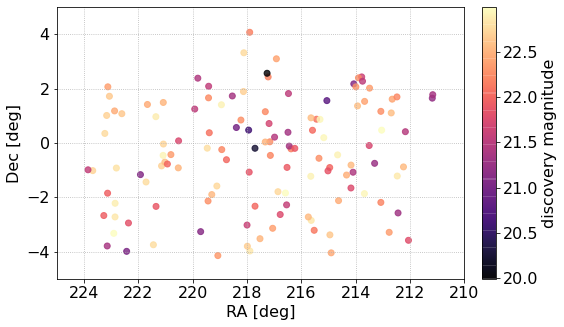

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

select = mag<mag_cut

sc = ax.scatter(coords.ra[select], coords.dec[select], c=mag[select], cmap='magma', alpha=0.8)
cb = fig.colorbar(sc, fraction=0.046, pad=0.04)
cb.set_label('discovery magnitude')
ax.set(aspect='equal',
       xlim=(225, 210), xlabel='RA [deg]',
       ylim=(-5,5), ylabel='Dec [deg]')
ax.grid(ls=':')

## Write ToO Ledger

In [7]:
def write_too_ledger(filename, too_table, checker, overwrite=False, verbose=False):
    """Write ToO ledger in the ECSV format specified by Adam Meyers.
    These can be passed to fiberassign for secondary targeting.
    
    Parameters
    ----------
    filename : str
        Output filename of the ledger (can be an absolute path).
    too_table : pandas.DataFrame
        Table of ToO data, using DECam format.
    checker : str
        Initials of individual(s) who have verified the ToO list.
    overwrite : bool
        If True, overwrite the output file.
    verbose : bool
        If True, 
    """
    mode = 'w' if overwrite else 'a'
    if verbose:
        mode = mode + '+'
    
    with open(filename, mode) as outf:
        for row in too_table:
            # Ledger format:
            # datatype:
            # - {name: RA, unit: deg, datatype: float64}
            # - {name: DEC, unit: deg, datatype: float64}
            # - {name: PMRA, unit: mas / yr, datatype: float32}
            # - {name: PMDEC, unit: mas / yr, datatype: float32}
            # - {name: REF_EPOCH, unit: yr, datatype: float32}
            # - {name: CHECKER, datatype: string}
            # - {name: TOO_TYPE, datatype: string}
            # - {name: OCLAYER, datatype: string}
            # - {name: MJD_BEGIN, unit: d, datatype: float64}
            # - {name: MJD_END, unit: d, datatype: float64}
            coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.hourangle, u.degree), frame='icrs')
            ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
            t_disc = Time(row['Discovery Date (UT)'], scale='utc')
            today = Time.now()

            mag  = row['Discovery Mag/Flux']
            prog = 'BRIGHT' #if mag < 21 else 'DARK'

            epoch = 2000.0

            outf.write('{:<10.6f} {:>10.6f} {:>9.6f} {:>9.6f} {:>7.1f}  {}  FIBER  {:7s} {:>15.8f} {:>15.8f}\n'.format(
                    ra, dec, 0, 0, epoch, checker, prog, t_disc.mjd, today.mjd+14))
    
        if verbose:
            outf.seek(0)
            for line in outf:
                print(line.strip())

In [8]:
write_too_ledger('desirt_too.ecsv', data[select], checker='SB', overwrite=True, verbose=True)

215.438300   0.871900  0.000000  0.000000  2000.0  SB  FIBER  DARK     59313.29583000  59334.35277805
221.713300  -1.438500  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.35145000  59334.35277807
221.442600  -3.747800  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.35416000  59334.35277809
215.644400   0.922600  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.26102000  59334.35277811
214.335900  -1.182500  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.27667000  59334.35277813
213.778400   2.428400  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.19680000  59334.35277814
223.161700   1.009500  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.33864000  59334.35277816
222.603600   1.074600  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.33864000  59334.35277818
221.661800   1.414000  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.33771000  59334.35277819
221.351400   0.964500  0.000000  0.000000  2000.0  SB  FIBER  DARK     59310.34048